In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns
from jax import random
from numpyro.handlers import do, seed
from numpyro.infer import Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
n = 1_000_000

rng_key, rng_subkey = random.split(rng_key)


def generate_data_1():
    x = numpyro.sample("x", dist.Normal(0, 1))
    y = numpyro.sample("y", dist.Normal(x + 1, np.sqrt(3)))
    return x, y


def generate_data_2():
    y = numpyro.sample("y", dist.Normal(1, 2))
    x = numpyro.sample("x", dist.Normal((y - 1) / 4, np.sqrt(3) / 2))
    return x, y


def generate_data_3():
    z = numpyro.sample("z", dist.Normal(0, 1))
    y = numpyro.sample("y", dist.Normal(z + 1, np.sqrt(3)))
    x = numpyro.sample("x", dist.Normal(z, 0.001))
    return x, y


rng_key, rng_subkey = random.split(rng_key)
x_1, y_1 = seed(generate_data_1, rng_subkey)()
x_2, y_2 = seed(generate_data_2, rng_subkey)()
x_3, y_3 = seed(generate_data_3, rng_subkey)()


In [3]:
rng_key, rng_subkey = random.split(rng_key)
trace_1 = Predictive(generate_data_1, num_samples=n)(rng_subkey)
x_1 = trace_1["x"]
y_1 = trace_1["y"]

rng_key, rng_subkey = random.split(rng_key)
trace_2 = Predictive(generate_data_2, num_samples=n)(rng_subkey)
x_2 = trace_2["x"]
y_2 = trace_2["y"]

rng_key, rng_subkey = random.split(rng_key)
trace_3 = Predictive(generate_data_3, num_samples=n)(rng_subkey)
x_3 = trace_3["x"]
y_3 = trace_3["y"]


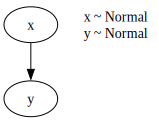

In [4]:
numpyro.render_model(
    model=generate_data_1,
    render_distributions=True,
    render_params=True,
)

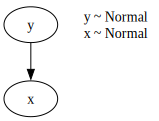

In [5]:
numpyro.render_model(
    model=generate_data_2,
    render_distributions=True,
    render_params=True,
)

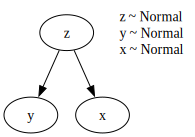

In [6]:
numpyro.render_model(
    model=generate_data_3,
    render_distributions=True,
    render_params=True,
)

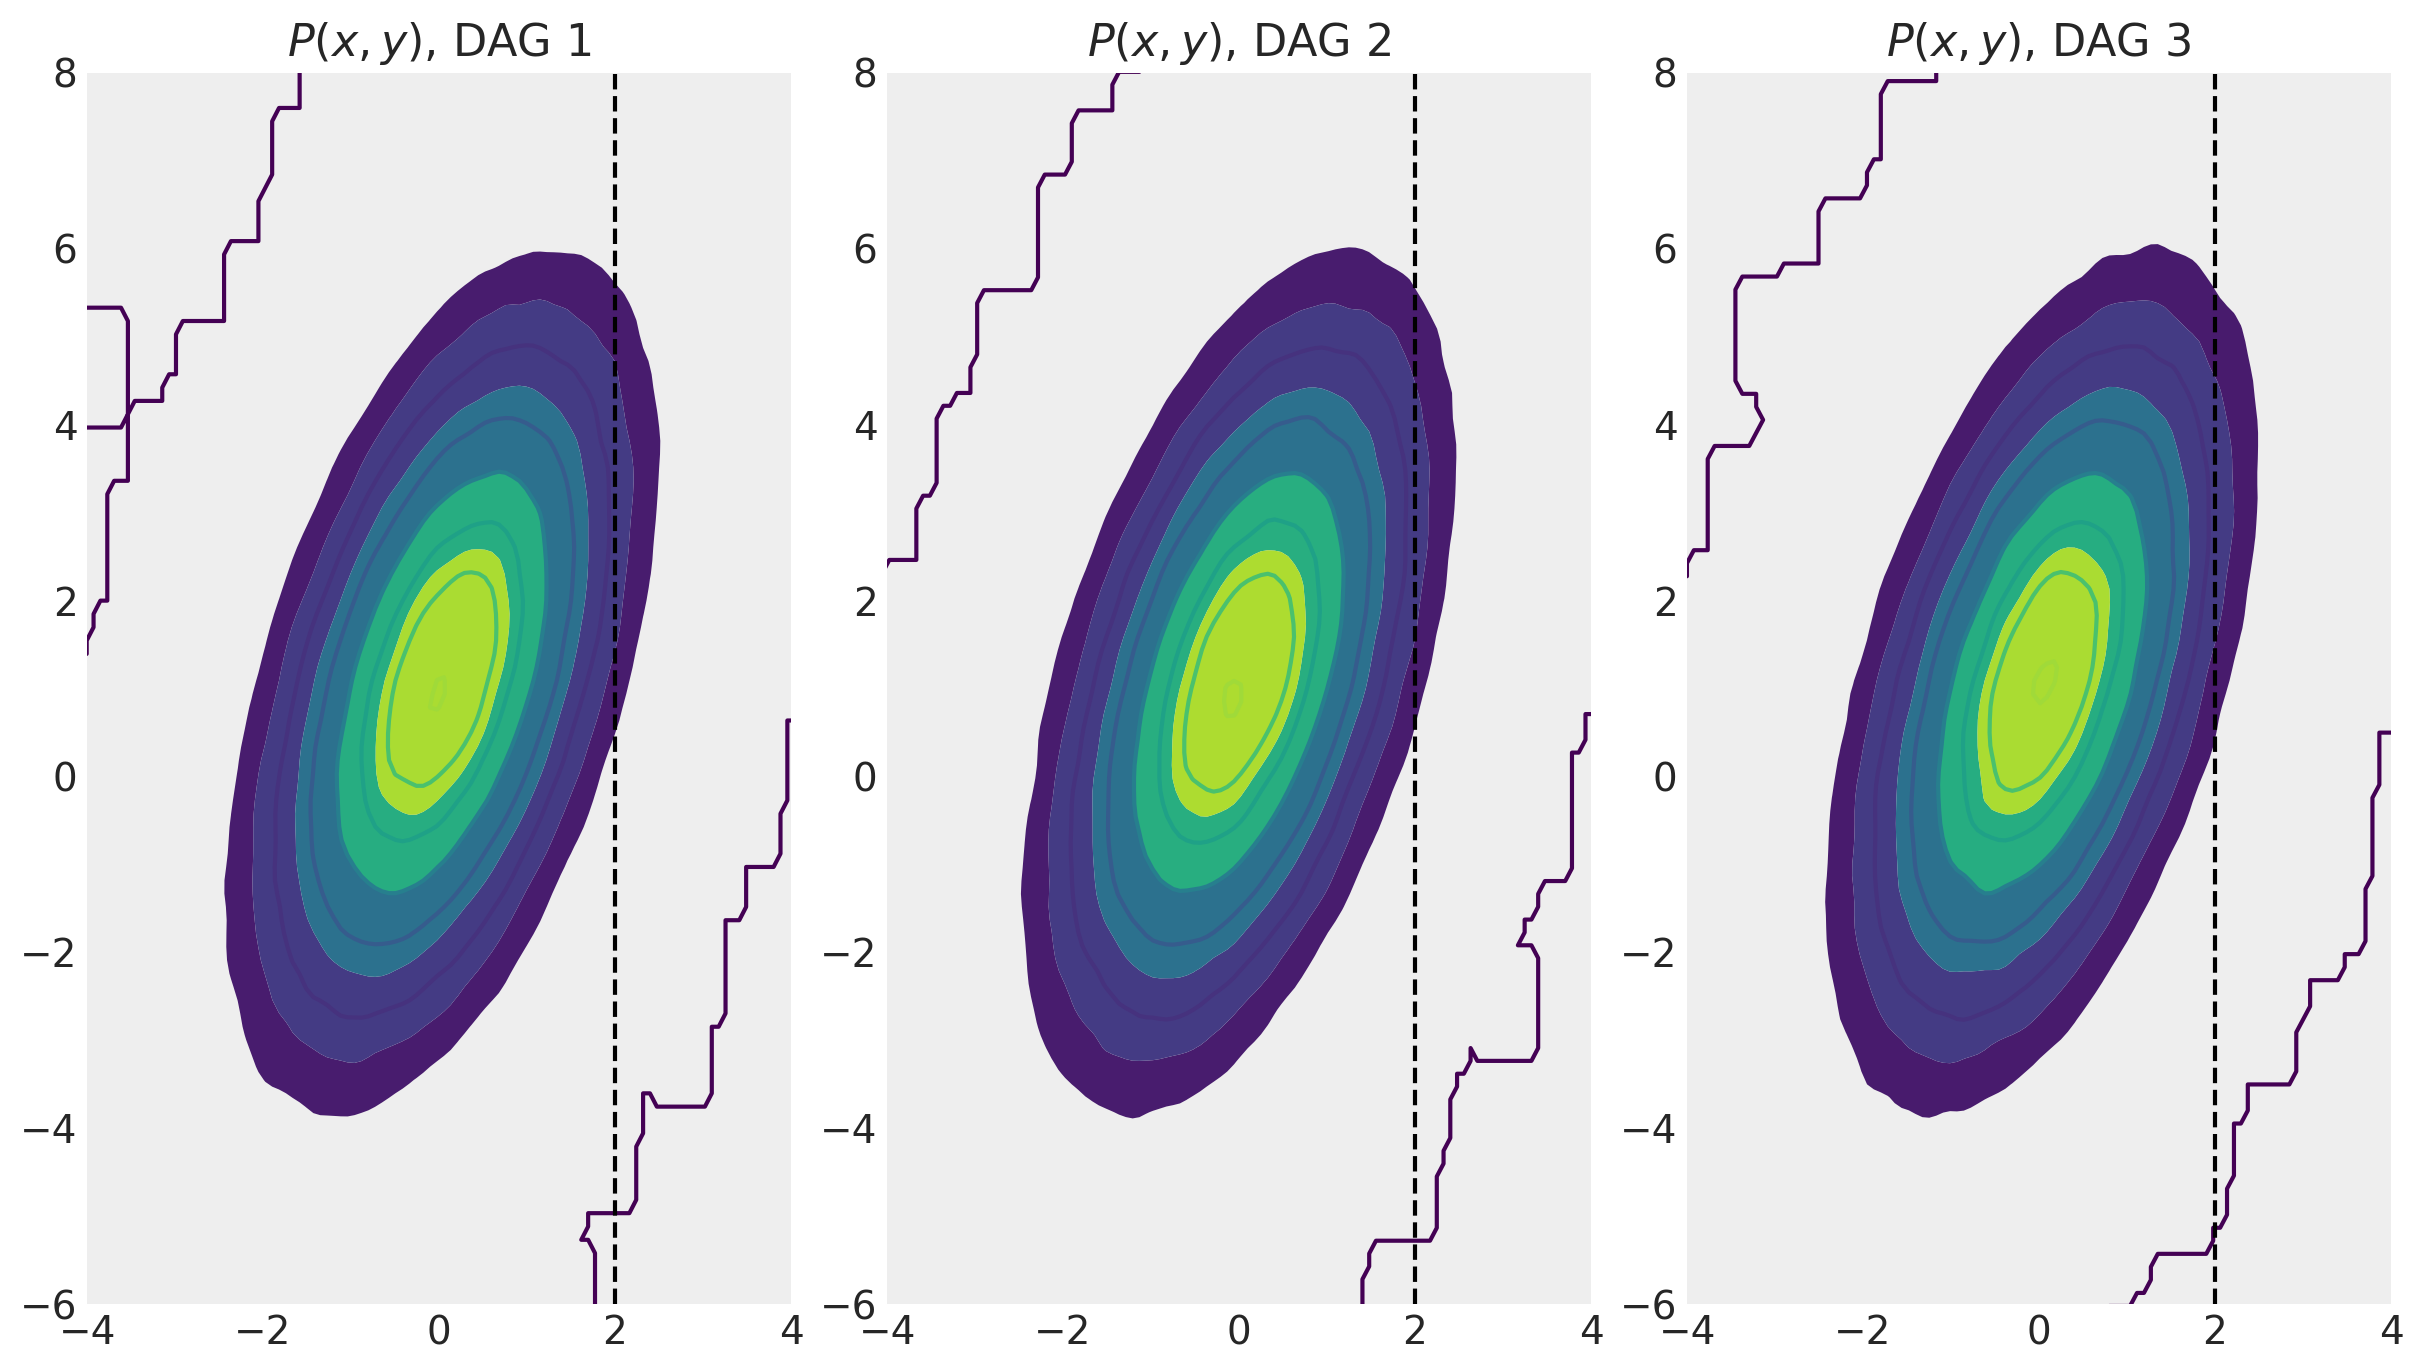

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, layout="constrained", figsize=(12, 8))

for i, (x, y) in enumerate([(x_1, y_1), (x_2, y_2), (x_3, y_3)]):
    az.plot_kde(
        np.array(x),
        np.array(y),
        hdi_probs=[0.25, 0.5, 0.75, 0.9, 0.95],
        contour_kwargs={"colors": None},
        contourf_kwargs={"alpha": 0.5},
        ax=ax[i],
    )
    ax[i].set(
        title=f"$P(x, y)$, DAG {i+1}",
        xlim=[-4, 4],
        xticks=np.arange(-4, 4 + 1, step=2),
        ylim=[-6, 8],
        yticks=np.arange(-6, 8 + 1, step=2),
        aspect="equal",
    )
    ax[i].axvline(x=2, ls="--", c="k")

In [8]:
do_model_1 = do(generate_data_1, {"x": 2})
do_model_2 = do(generate_data_2, {"x": 2})
do_model_3 = do(generate_data_3, {"x": 2})

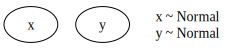

In [9]:
numpyro.render_model(
    model=do_model_1,
    render_distributions=True,
    render_params=True,
)


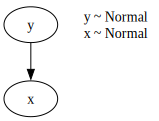

In [10]:
numpyro.render_model(
    model=do_model_2,
    render_distributions=True,
    render_params=True,
)


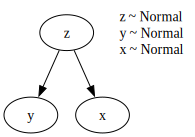

In [11]:
numpyro.render_model(
    model=do_model_3,
    render_distributions=True,
    render_params=True,
)

In [12]:
rng_key, rng_subkey = random.split(rng_key)
trace_1_do = Predictive(do_model_1, num_samples=n)(rng_subkey)
trace_2_do = Predictive(do_model_2, num_samples=n)(rng_subkey)
trace_3_do = Predictive(do_model_3, num_samples=n)(rng_subkey)

x_1_do = trace_1_do["x"]
y_1_do = trace_1_do["y"]

x_2_do = trace_2_do["x"]
y_2_do = trace_2_do["y"]

x_3_do = trace_3_do["x"]
y_3_do = trace_3_do["y"]


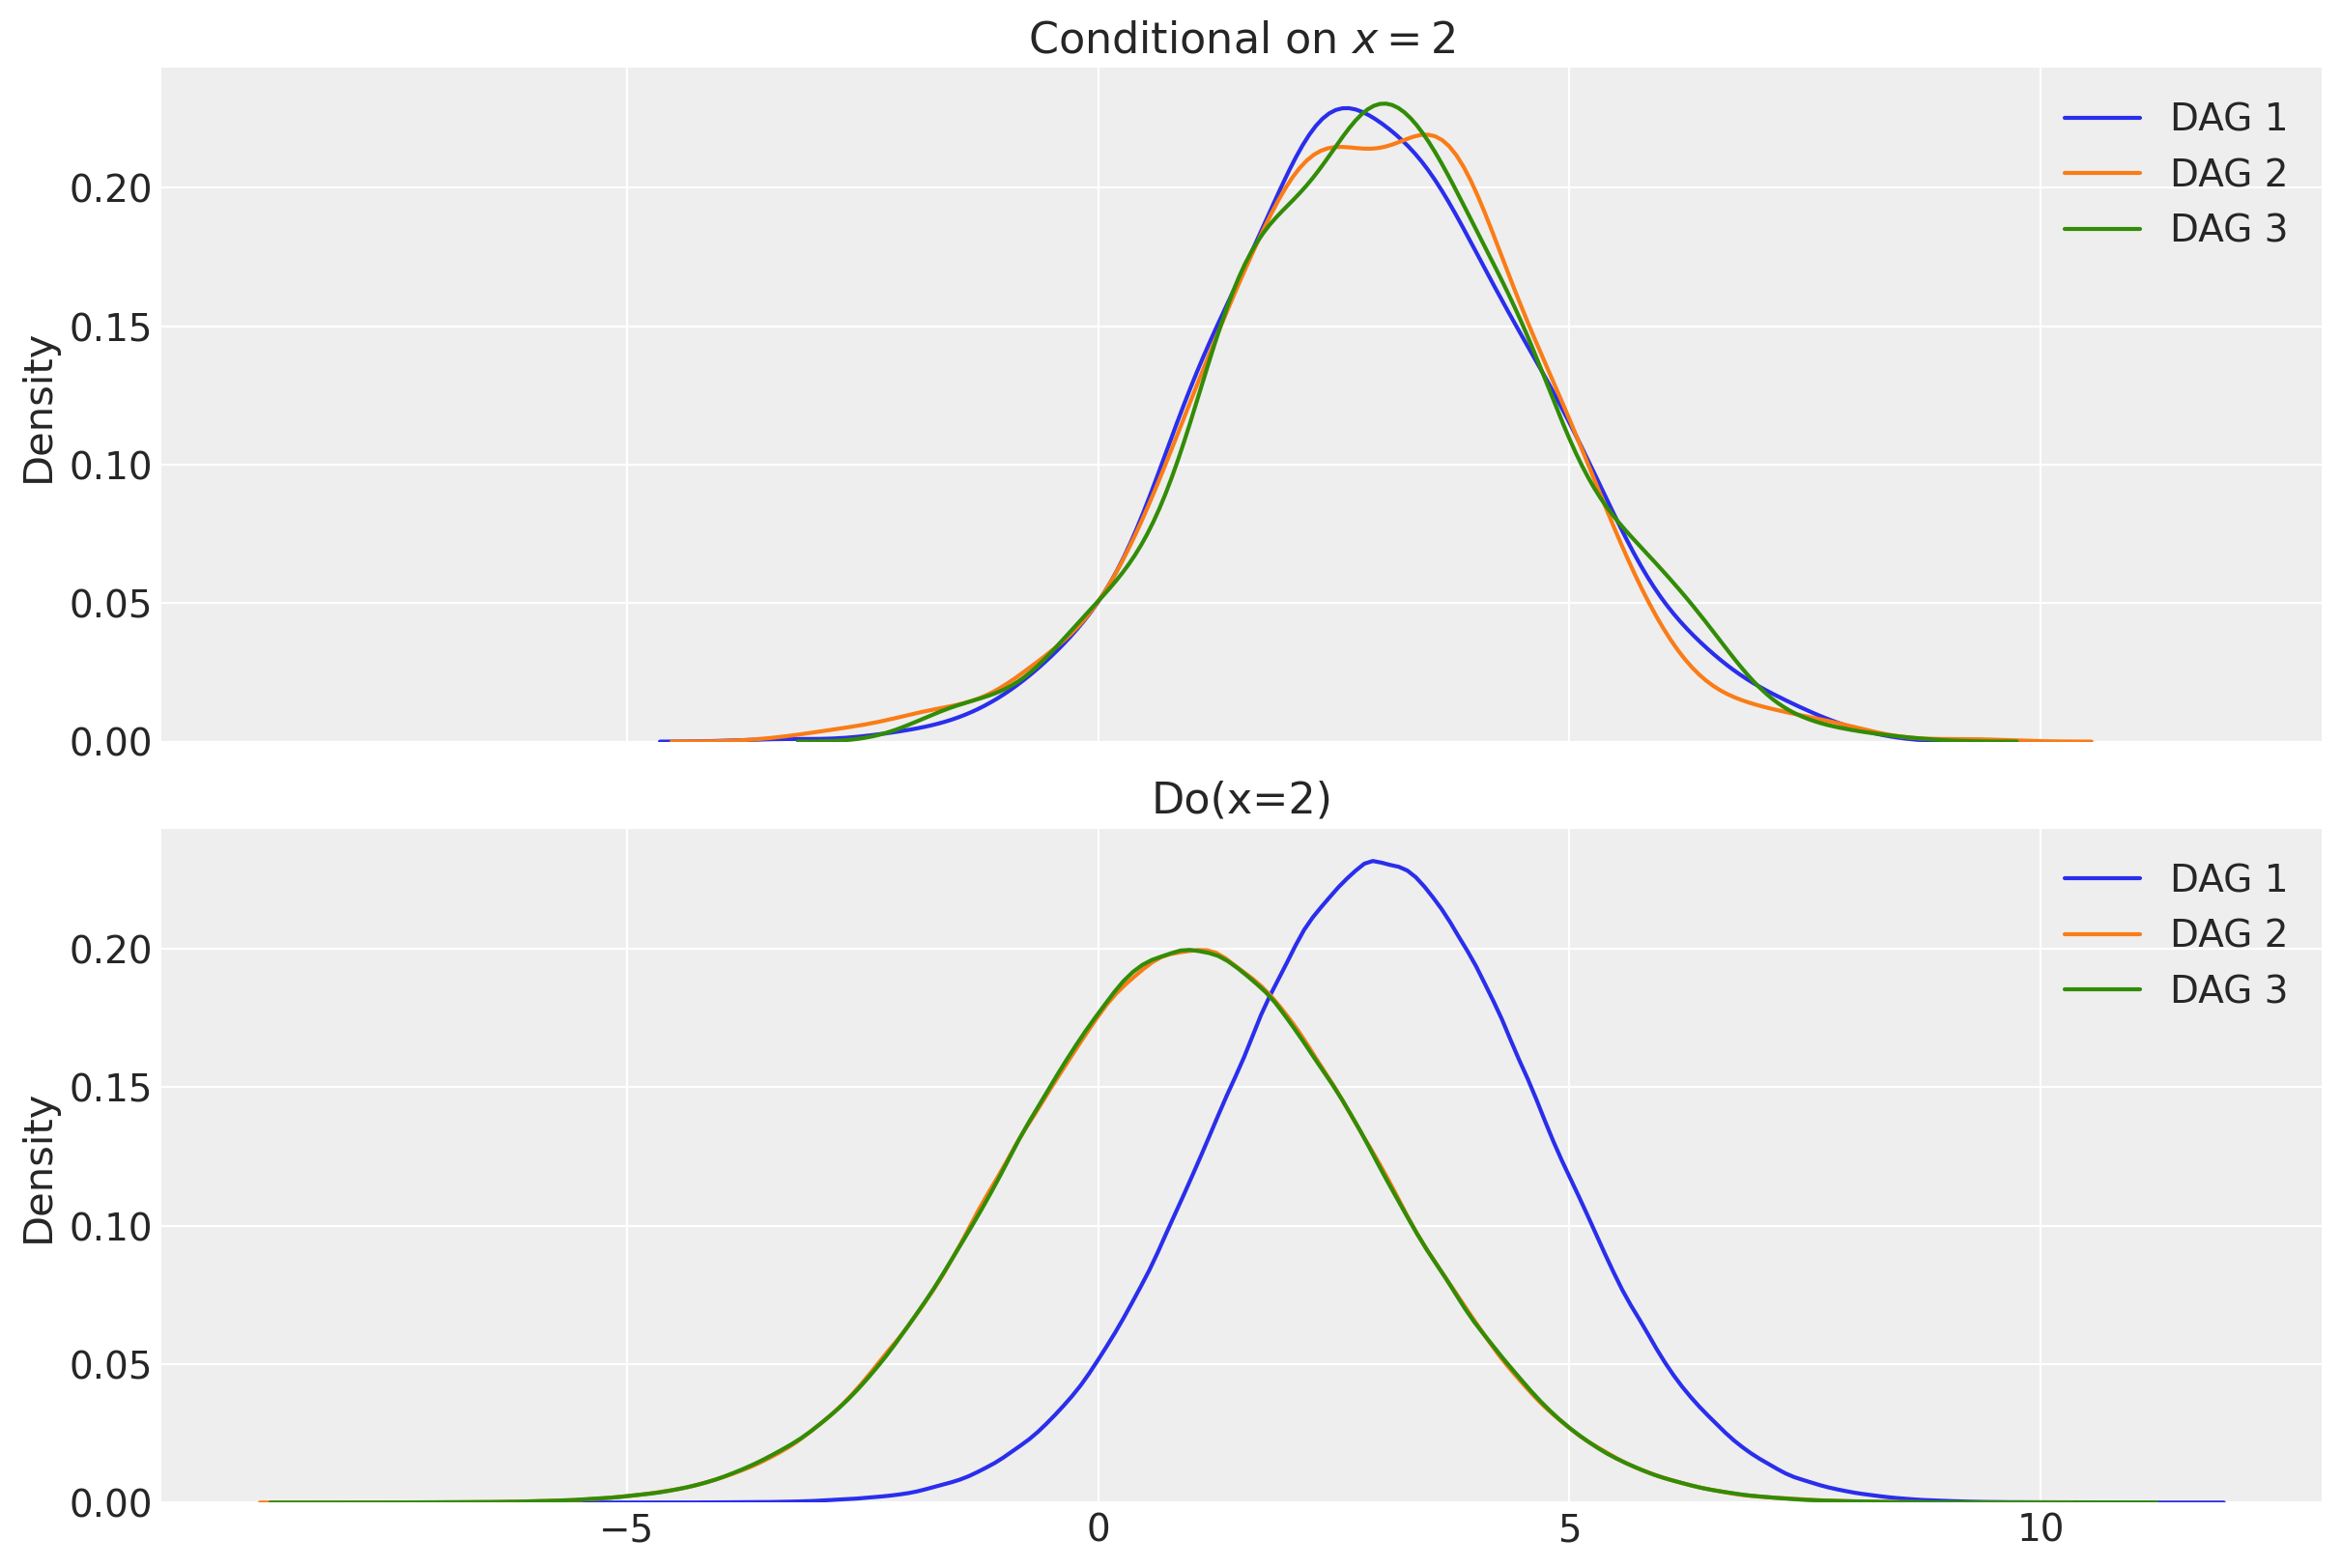

In [13]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    sharey=True,
    layout="constrained",
    figsize=(12, 8),
)

sns.kdeplot(np.array(y_1[(x_1 > 1.99) & (x_1 < 2.01)]), c="C0", label="DAG 1", ax=ax[0])
sns.kdeplot(np.array(y_2[(x_2 > 1.99) & (x_2 < 2.01)]), c="C1", label="DAG 2", ax=ax[0])
sns.kdeplot(np.array(y_3[(x_3 > 1.99) & (x_3 < 2.01)]), c="C2", label="DAG 3", ax=ax[0])
ax[0].legend()
ax[0].set(title="Conditional on $x=2$")

sns.kdeplot(np.array(y_1_do), c="C0", label="DAG 1", ax=ax[1])
sns.kdeplot(np.array(y_2_do), c="C1", label="DAG 2", ax=ax[1])
sns.kdeplot(np.array(y_3_do), c="C2", label="DAG 3", ax=ax[1])
ax[1].set(title="Do(x=2)")
ax[1].legend()
